Neste notebook, vamos mostrar como calcular o Moran's Index univariado e bivariado utilizando dados de pluviometria e temperatura do INMET (Instituto Nacional de Meteorologia) de abril de 2021.

In [1]:
## Bibliotecas para tratamento de dados, plotting e leitura de arquivos de dados
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob

## Geopandas: Utilizamos para conseguir ler arquivos do tipo Shape (.shp) 
import geopandas as gpd

## Pacotes PySAL
# libpysal: Biblioteca core do PySAL. Utilizamos o método de vizinhança Queen
from libpysal.weights.contiguity import Queen
# ESDA (Exploratory Spatial Data Analysis): utilizamos para o cálculo de correlação
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
# SPlot: Utilizamos para fazer os plots espaciais
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster, plot_moran_bv

# Para exibirmos várias linhas e colunas
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [2]:
MAPAS_PATH = "BR_UF_2020/"
DATA_PATH = "Histórico de Dados Meteorológicos - 2021/"

## Computamos as vizinhanças e pesos

Carregamos o shape file

<AxesSubplot:>

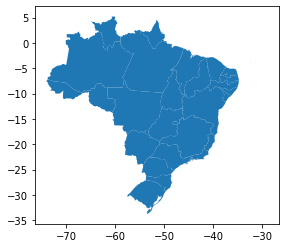

In [3]:
gdf = gpd.read_file(MAPAS_PATH + "BR_UF_2020.shp")
gdf.plot()

In [4]:
gdf

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4..."
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828..."
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620..."
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416..."
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ..."
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2..."
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23291 -5.94757, -48.23163 -5.946..."
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.96620 -1.27114, -44.96081 ..."
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91509 -6.64795, -42.91636 -6.644..."
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017..."


In [5]:
gdf.shape

(27, 5)

Aqui setamos o tipo de contiguidade que desejamos. Existem dois tipos predefinidos para definir vizinhança, que são o `Rook` e o `Queen`. A contiguidade `Rook` considera vizinhos aquelas regiões que têm bordas em comum. A contiguidade `Queen` é uma extensão da contiguidade `Rook` que considera também como vizinhas aquelas regiões cuja borda contém somente um ponto em comum. O nome vem das peças do jogo de xadrez, e os métodos têm bastante diferença quando nossas regiões estão dispostas em _grid_ [[1]](#refs).

Aqui, vamos considerar o método `Queen` para calcular a matriz de contiguidade, mas o método `Rook` também poderia ser utilizado.

O resultado é uma matriz esparsa binária, indicando se uma região é vizinha de outra (1) ou não (0).

In [6]:
weights = Queen.from_dataframe(gdf)

In [7]:
W_matrix, ids = weights.full()

In [8]:
W_matrix[0] # notar que é uma matriz de 0's e 1's

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

Vamos também normalizar a matriz por linhas (`r`) usando a função `transform` [[2]](#refs).

In [9]:
weights.transform = 'r'

In [10]:
W_matrix, ids = weights.full()

In [11]:
W_matrix[0] # notar que é os 1's foram normalizados

array([0.        , 0.33333333, 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.        , 0.        ])

Vemos quantos não zeros temos na matriz.

In [12]:
str(np.round(weights.pct_nonzero, 2)) + "%"

'13.99%'

Vemos quantas regiões temos (`n`). Nossa matriz tem `n * n` valores.

In [13]:
weights.n

27

De fato, temos 27 UFs no Brasil (26 estados mais o Distrito Federal).

## Preparamos os dados de pluviometria

Vamos carregar os dados meteorológicos de todas as cidades brasileiras disponíveis. [[3]](#refs)

In [14]:
df_meteorologicos = pd.DataFrame()

In [15]:
meteo_file_paths = glob.glob(DATA_PATH + "INMET*.CSV")
meteo_file_paths

['Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A002_GOIANIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A003_MORRINHOS_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A005_PORANGATU_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A011_SAO SIMAO_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A012_LUZIANIA_

In [16]:
%%time
for path in meteo_file_paths:
    try:
        print(f"Lendo arquivo {path}...")
        df_file = pd.read_csv(path, encoding="ISO-8859-1", sep=";", header=8)
        print(f"Arquivo {path} lido com sucesso!")
        # Adicionamos as informações da cidade e do estado, presentes no nome do arquivo
        filename = path.split('\\')[1]
        region = filename.split("_")[1]
        uf = filename.split("_")[2]
        city = filename.split("_")[4]
        print(f"Arquivo referente a {uf} - {city}")
        df_file["Região"] = region
        df_file["UF"] = uf
        df_file["Cidade"] = city
        # Concatenamos o dataframe da cidade
        df_meteorologicos = pd.concat([df_meteorologicos, df_file])
        print(f"Shape final: {df_meteorologicos.shape}")
    except Exception as e:
        print(f"Falha ao ler arquivo {path} :-(")
        print(e)
    print()

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - BRASILIA
Shape final: (2880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - BRAZLANDIA
Shape final: (5760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - AGUAS EMENDADAS
Shape final: (8640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2


Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A037_SILVANIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A037_SILVANIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a GO - SILVANIA
Shape final: (86400, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A056_CRISTALINA (FAZENDA SANTA MONICA)_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A056_CRISTALINA (FAZENDA SANTA MONICA)_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a GO - CRISTALINA (FAZENDA SANTA MONICA)
Shape final: (89280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A702_CAMPO GRANDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A702_CAMPO GRANDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - CAMPO GRANDE
Shape final: (92160, 23)

Lendo arquivo Histórico de Dados 

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S701_ANGELICA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - ANGELICA
Shape final: (172800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S702_ARAL MOREIRA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S702_ARAL MOREIRA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - ARAL MOREIRA
Shape final: (175680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S703_BANDEIRANTES_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S703_BANDEIRANTES_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - BANDEIRANTES
Shape final: (178560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S704_BONITO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S704_BONITO_01-01-2021_A_30-04-2021

Shape final: (250560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A912_CAMPO VERDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A912_CAMPO VERDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - CAMPO VERDE
Shape final: (253440, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A913_COMODORO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A913_COMODORO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - COMODORO
Shape final: (256320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A914_JUARA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A914_JUARA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - JUARA
Shape final: (259200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A915_PARANATINGA_01-01-2

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A303_MACEIO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AL - MACEIO
Shape final: (328320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A323_PAO DE ACUCAR_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A323_PAO DE ACUCAR_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AL - PAO DE ACUCAR
Shape final: (331200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A327_PALMEIRA DOS INDIOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A327_PALMEIRA DOS INDIOS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AL - PALMEIRA DOS INDIOS
Shape final: (334080, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A353_ARAPIRACA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A353_ARAPIRA

Shape final: (408960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A430_PIATA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A430_PIATA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - PIATA
Shape final: (411840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A431_CONDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A431_CONDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - CONDE
Shape final: (414720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A432_BURITIRAMA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A432_BURITIRAMA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - BURITIRAMA
Shape final: (417600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A433_BRUMADO_01-01-2021_A_30-04-2021

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A315_BARBALHA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - BARBALHA
Shape final: (492480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A319_IGUATU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A319_IGUATU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - IGUATU
Shape final: (495360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A324_TAUA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A324_TAUA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - TAUA
Shape final: (498240, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A325_QUIXERAMOBIM_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A325_QUIXERAMOBIM_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo

Shape final: (576000, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A310_AREIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A310_AREIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PB - AREIA
Shape final: (578880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A313_CAMPINA GRANDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A313_CAMPINA GRANDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PB - CAMPINA GRANDE
Shape final: (581760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A320_JOAO PESSOA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A320_JOAO PESSOA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PB - JOAO PESSOA
Shape final: (584640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A321_P

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A335_PIRIPIRI_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - PIRIPIRI
Shape final: (659520, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A336_ALVORADA DO GURGUEIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A336_ALVORADA DO GURGUEIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - ALVORADA DO GURGUEIA
Shape final: (662400, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A337_CARACOL_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A337_CARACOL_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - CARACOL
Shape final: (665280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A343_PICOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A343_PICOS_01-01-2021_A_30-

Shape final: (740160, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A451_ITABAIANA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A451_ITABAIANA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SE - ITABAIANA
Shape final: (743040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A453_NOSSA SENHORA DA GLORIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A453_NOSSA SENHORA DA GLORIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SE - NOSSA SENHORA DA GLORIA
Shape final: (745920, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AC_A102_PARQUE ESTADUAL CHANDLESS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AC_A102_PARQUE ESTADUAL CHANDLESS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AC - PARQUE ESTADUAL CHANDLESS
Shape final: (748800,

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A144_NOVO ARIPUANA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AM - NOVO ARIPUANA
Shape final: (820800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A242_OIAPOQUE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A242_OIAPOQUE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AP - OIAPOQUE
Shape final: (823680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A244_PORTO GRANDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A244_PORTO GRANDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AP - PORTO GRANDE
Shape final: (826560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A249_MACAPA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A249_MACAPA_01-01-2021_A_30-04-2021.CSV lido

Shape final: (904320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A247_XINGUARA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A247_XINGUARA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - XINGUARA
Shape final: (907200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A248_CAPITAO POCO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A248_CAPITAO POCO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - CAPITAO POCO
Shape final: (910080, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A250_SANTAREM_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A250_SANTAREM_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - SANTAREM
Shape final: (912960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A252_DOM ELISEU_01-

Shape final: (984960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A052_SANTA ROSA DO TOCANTINS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A052_SANTA ROSA DO TOCANTINS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a TO - SANTA ROSA DO TOCANTINS
Shape final: (987840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A053_ALMAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A053_ALMAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a TO - ALMAS
Shape final: (990720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A054_ARAGUACU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A054_ARAGUACU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a TO - ARAGUACU
Shape final: (993600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_

Shape final: (1065600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A515_VARGINHA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A515_VARGINHA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - VARGINHA
Shape final: (1068480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A516_PASSOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A516_PASSOS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - PASSOS
Shape final: (1071360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A517_MURIAE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A517_MURIAE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - MURIAE
Shape final: (1074240, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A518_JUIZ DE FORA_01-01-2021_A_3

Shape final: (1224000, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_F501_BELO HORIZONTE - CERCADINHO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_F501_BELO HORIZONTE - CERCADINHO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - BELO HORIZONTE - CERCADINHO
Shape final: (1226880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A601_SEROPEDICA-ECOLOGIA AGRICOLA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A601_SEROPEDICA-ECOLOGIA AGRICOLA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RJ - SEROPEDICA-ECOLOGIA AGRICOLA
Shape final: (1229760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A602_RIO DE JANEIRO-MARAMBAIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A602_RIO DE JANEIRO-MARAMBAIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!


Shape final: (1298880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A667_SAQUAREMA - SAMPAIO CORREIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_RJ_A667_SAQUAREMA - SAMPAIO CORREIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RJ - SAQUAREMA - SAMPAIO CORREIA
Shape final: (1301760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - SAO PAULO - MIRANTE
Shape final: (1304640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A705_BAURU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A705_BAURU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - BAURU
Shape final: (1307520, 23)

Lendo 

Shape final: (1376640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A744_BRAGANCA PAULISTA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A744_BRAGANCA PAULISTA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - BRAGANCA PAULISTA
Shape final: (1379520, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A746_BARRA DO TURVO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A746_BARRA DO TURVO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - BARRA DO TURVO
Shape final: (1382400, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A747_PRADOPOLIS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_SP_A747_PRADOPOLIS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SP - PRADOPOLIS
Shape final: (1385280, 23)

Lendo arquivo Histórico de Dados Met

Shape final: (1457280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A843_DOIS VIZINHOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A843_DOIS VIZINHOS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PR - DOIS VIZINHOS
Shape final: (1460160, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A846_FOZ DO IGUACU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A846_FOZ DO IGUACU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PR - FOZ DO IGUACU
Shape final: (1463040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A849_DIAMANTE DO NORTE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_PR_A849_DIAMANTE DO NORTE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PR - DIAMANTE DO NORTE
Shape final: (1465920, 23)

Lendo arquivo Histórico de Dados Met

Shape final: (1535040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A827_BAGE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A827_BAGE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - BAGE
Shape final: (1537920, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A828_ERECHIM_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A828_ERECHIM_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - ERECHIM
Shape final: (1540800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A829_SAO JOSE DOS AUSENTES_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A829_SAO JOSE DOS AUSENTES_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - SAO JOSE DOS AUSENTES
Shape final: (1543680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A83

Shape final: (1615680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A893_ENCRUZILHADA DO SUL_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A893_ENCRUZILHADA DO SUL_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - ENCRUZILHADA DO SUL
Shape final: (1618560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A894_SERAFINA CORREA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A894_SERAFINA CORREA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - SERAFINA CORREA
Shape final: (1621440, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A897_CAMBARA DO SUL_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_RS_A897_CAMBARA DO SUL_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a RS - CAMBARA DO SUL
Shape final: (1624320, 23)

Lendo arquivo Históri

Shape final: (1693440, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A898_CAMPOS NOVOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_S_SC_A898_CAMPOS NOVOS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SC - CAMPOS NOVOS
Shape final: (1696320, 23)

Wall time: 1min 44s


In [17]:
df_meteorologicos.reset_index(drop=True, inplace=True)

In [18]:
df_meteorologicos.head()

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,Região,UF,Cidade
0,2021/01/01,0000 UTC,0,"887,1","887,1","886,3",NaN,"20,9","15,9","22,4","20,8","16,5","15,4",75.0,67.0,73.0,327.0,"3,6",",8",NaN,CO,DF,BRASILIA
1,2021/01/01,0100 UTC,0,"887,3","887,5","887,1",NaN,"20,5","16,4","21,1","19,5","16,9",16,83.0,73.0,78.0,134.0,"2,3","1,5",NaN,CO,DF,BRASILIA
2,2021/01/01,0200 UTC,0,"887,9",888,"887,2",NaN,"19,6","16,1","21,4","19,6","16,5","15,9",80.0,73.0,80.0,309.0,"2,5","1,1",NaN,CO,DF,BRASILIA
3,2021/01/01,0300 UTC,0,"887,6",888,"887,6",NaN,"19,4","16,7","20,1","19,3",17,"16,1",86.0,78.0,84.0,315.0,"2,3",",6",NaN,CO,DF,BRASILIA
4,2021/01/01,0400 UTC,0,887,"887,6",887,NaN,"18,7","16,3","19,4","18,6","16,8",16,86.0,83.0,86.0,270.0,"1,4",",7",NaN,CO,DF,BRASILIA


In [19]:
df_meteorologicos.shape

(1696320, 23)

In [20]:
print(f"Temos {len(df_meteorologicos['Cidade'].unique())} cidades diferentes.")

Temos 587 cidades diferentes.


Separamos os dados de Precipitação

In [21]:
df_precipitacao = df_meteorologicos[["Data", "Hora UTC", "Região", "UF", "Cidade", "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"]]

In [22]:
df_precipitacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696320 entries, 0 to 1696319
Data columns (total 6 columns):
 #   Column                            Dtype 
---  ------                            ----- 
 0   Data                              object
 1   Hora UTC                          object
 2   Região                            object
 3   UF                                object
 4   Cidade                            object
 5   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  object
dtypes: object(6)
memory usage: 77.7+ MB


Transformamos os campos de data e de precipitação

In [23]:
df_precipitacao["Data"].value_counts(dropna=False).sort_index()

2021/01/01    14136
2021/01/02    14136
2021/01/03    14136
2021/01/04    14136
2021/01/05    14136
2021/01/06    14136
2021/01/07    14136
2021/01/08    14136
2021/01/09    14136
2021/01/10    14136
2021/01/11    14136
2021/01/12    14136
2021/01/13    14136
2021/01/14    14136
2021/01/15    14136
2021/01/16    14136
2021/01/17    14136
2021/01/18    14136
2021/01/19    14136
2021/01/20    14136
2021/01/21    14136
2021/01/22    14136
2021/01/23    14136
2021/01/24    14136
2021/01/25    14136
2021/01/26    14136
2021/01/27    14136
2021/01/28    14136
2021/01/29    14136
2021/01/30    14136
2021/01/31    14136
2021/02/01    14136
2021/02/02    14136
2021/02/03    14136
2021/02/04    14136
2021/02/05    14136
2021/02/06    14136
2021/02/07    14136
2021/02/08    14136
2021/02/09    14136
2021/02/10    14136
2021/02/11    14136
2021/02/12    14136
2021/02/13    14136
2021/02/14    14136
2021/02/15    14136
2021/02/16    14136
2021/02/17    14136
2021/02/18    14136
2021/02/19    14136


In [24]:
df_precipitacao["Data"] = pd.to_datetime(df_precipitacao["Data"], format="%Y/%m/%d")

C:\Users\marco\anaconda3\envs\spatial\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [25]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].value_counts(dropna=False)

0       824477
NaN     777547
,2       27191
0.0      16568
,4        8646
,6        5467
,8        4047
1         3100
1,2       2499
1,4       2123
1,6       1799
1,8       1560
2         1380
2,2       1270
2,4       1054
2,6        963
2,8        936
3          803
3,2        773
3,4        700
3,6        644
3,8        623
4          552
4,2        538
4,6        453
4,4        450
4,8        384
5,2        368
5,4        368
5,6        344
5          334
5,8        329
6          282
6,2        265
6,4        252
7          242
7,2        240
6,6        237
6,8        237
7,4        206
7,6        203
8          179
7,8        178
8,2        174
8,4        155
8,8        151
8,6        148
9,6        140
9          133
9,2        132
9,4        130
9,8        112
10,2       110
10         110
11         106
10,4       105
10,8        98
12          94
11,2        88
12,4        88
11,8        87
13,8        86
13,2        86
12,6        84
13          77
10,6        74
12,2      

In [26]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"] = df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].str.replace(",", ".").astype(np.float64)

Vamos utilizar somente os dados de abril de 2021

In [27]:
df_precipitacao = df_precipitacao[(df_precipitacao["Data"] >= "2021-04-01") & (df_precipitacao["Data"] <= "2021-04-30")]

In [28]:
print(f"Temos dados de {len(df_precipitacao['UF'].unique())} UFs em 2021-04.")

Temos dados de 27 UFs em 2021-04.


In [29]:
df_precipitacao

,Data,Hora UTC,Região,UF,Cidade,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"
2160,2021-04-01,0000 UTC,CO,DF,BRASILIA,1.2
2161,2021-04-01,0100 UTC,CO,DF,BRASILIA,0.0
2162,2021-04-01,0200 UTC,CO,DF,BRASILIA,0.0
2163,2021-04-01,0300 UTC,CO,DF,BRASILIA,6.0
2164,2021-04-01,0400 UTC,CO,DF,BRASILIA,0.8
...,...,...,...,...,...,...
1696315,2021-04-30,1900 UTC,S,SC,CAMPOS NOVOS,0.0
1696316,2021-04-30,2000 UTC,S,SC,CAMPOS NOVOS,0.0
1696317,2021-04-30,2100 UTC,S,SC,CAMPOS NOVOS,0.0
1696318,2021-04-30,2200 UTC,S,SC,CAMPOS NOVOS,0.0


Vamos tirar a média das pluviometrias em cada estado

In [30]:
df_precipitacao.groupby("UF")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()

UF
AC    0.185112
AL    0.049880
AM    0.266056
AP    0.347717
BA    0.153503
CE    0.218500
DF    0.138316
ES    0.080754
GO    0.120716
MA    0.141367
MG    0.049441
MS    0.025402
MT    0.103892
PA    0.352129
PB    0.147743
PE    0.205421
PI    0.118991
PR    0.027940
RJ    0.120208
RN    0.121946
RO    0.158611
RR         NaN
RS    0.058158
SC    0.052660
SE    0.137697
SP    0.050138
TO    0.196856
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64

Temos só nulos em Roraima, no mês de 04-2021. Vamos imputar a média da região Norte

In [31]:
medias_por_regiao = df_precipitacao.groupby("Região")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()
medias_por_regiao

Região
CO    0.084972
N     0.280433
NE    0.153923
S     0.050806
SE    0.065629
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64

In [32]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"] = df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].fillna(medias_por_regiao["N"])

Calculamos as médias pluviométricas de cada estado

In [33]:
medias_por_uf = df_precipitacao.groupby("UF")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()
medias_por_uf

UF
AC    0.265189
AL    0.165797
AM    0.276650
AP    0.312160
BA    0.228337
CE    0.257359
DF    0.138356
ES    0.131122
GO    0.172735
MA    0.227068
MG    0.080901
MS    0.176689
MT    0.230718
PA    0.309737
PB    0.214211
PE    0.225737
PI    0.216508
PR    0.164384
RJ    0.155146
RN    0.257810
RO    0.219522
RR    0.280433
RS    0.116000
SC    0.106770
SE    0.202976
SP    0.169875
TO    0.248314
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), dtype: float64

Vamos utilizar uma abordagem por estado brasileiro, para simplificar o cálculo, assim como a aplicada no [artigo 1](https://marcospaulomoretti.medium.com/autocorrela%C3%A7%C3%A3o-espacial-382c5af6d2ed), por dois motivos:
- Não temos os dados pluviométricas de todos os municípios (temos 589/5570).
- Nos dados pluviométricos não tem o CODMUN (código do município), então precisaríamos fazer um match de string.

Ao contrário do [artigo 1](https://marcospaulomoretti.medium.com/autocorrela%C3%A7%C3%A3o-espacial-382c5af6d2ed), estamos utilizando dados de 04/2021, pois na data de obtenção dos dados do INMET ainda não havia os dados de 05/2021.

In [34]:
df_medias_pluviometricas = pd.DataFrame(medias_por_uf).reset_index()
df_medias_pluviometricas.rename(columns={"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)" : "MÉDIA PLUVIOMÉTRICA EM ABR/2021"}, inplace=True)
df_medias_pluviometricas

,UF,MÉDIA PLUVIOMÉTRICA EM ABR/2021
0,AC,0.265189
1,AL,0.165797
2,AM,0.276650
3,AP,0.312160
4,BA,0.228337
5,CE,0.257359
6,DF,0.138356
7,ES,0.131122
8,GO,0.172735
9,MA,0.227068


Criamos um novo dataframe com o Geometry (em `gdf`) e o dado pluviométrico. Assim, acabamos por ordenar a variável de Média Pluviométrica de acordo com a ordenação dos estados em `gdf`.

In [35]:
df_final = pd.merge(
    gdf,
    df_medias_pluviometricas,
    left_on="SIGLA_UF",
    right_on="UF",
    how="left"
)

In [36]:
df_final

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,UF,MÉDIA PLUVIOMÉTRICA EM ABR/2021
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",RO,0.219522
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828...",AC,0.265189
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620...",AM,0.276650
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416...",RR,0.280433
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...",PA,0.309737
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",AP,0.312160
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23291 -5.94757, -48.23163 -5.946...",TO,0.248314
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.96620 -1.27114, -44.96081 ...",MA,0.227068
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91509 -6.64795, -42.91636 -6.644...",PI,0.216508
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017...",CE,0.257359


## Cálculo do Moran's I

In [37]:
help(Moran)

Help on class Moran in module esda.moran:

class Moran(builtins.object)
 |  Moran(y, w, transformation='r', permutations=999, two_tailed=True)
 |  
 |  Moran's I Global Autocorrelation Statistic
 |  
 |  Parameters
 |  ----------
 |  
 |  y               : array
 |                    variable measured across n spatial units
 |  w               : W
 |                    spatial weights instance
 |  transformation  : string
 |                    weights transformation,  default is row-standardized "r".
 |                    Other options include "B": binary,  "D":
 |                    doubly-standardized,  "U": untransformed
 |                    (general weights), "V": variance-stabilizing.
 |  permutations    : int
 |                    number of random permutations for calculation of
 |                    pseudo-p_values
 |  two_tailed      : boolean
 |                    If True (default) analytical p-values for Moran are two
 |                    tailed, otherwise if False, they ar

* #### Autocorrelação espacial global

Medida da autocorrelação espacial da variável `MÉDIA PLUVIOMÉTRICA EM ABR/2021` (chamamos de `y`)

In [38]:
y = df_final["MÉDIA PLUVIOMÉTRICA EM ABR/2021"].copy()

In [39]:
moran = Moran(y, weights)

In [40]:
moran.I

0.7695038792652196

O valor de autocorrelação é **positivo.**

```
The Spatial Autocorrelation (Global Moran's I) tool is an inferential statistic, which means that the results of the analysis are always interpreted within the context of its null hypothesis. 
```
(Fonte: [[4]](#refs))

O valor do Moran's I é uma estatística que deve ser avaliada no contexto de um teste de hipótese sobre a aleatoriedade da distribuição dos valores de `y` no espaço.


Na prática, o valor do índice calculado com `moran.I` é um valor normalizado: calcula-se sua esperança teórica, calcula-se seu desvio-padrão teórico, e o Moran's I é o _z-score_ ($I = \frac{I - E(I)}{std(I)}$). É a partir dessa estatística que aceitamos ou rejeitamos a hipótese inicial (H0) de os dados de `y` estarem distribuídos no espaço de forma aleatória. [[5]](#refs)

A significância do valor de Moran's I pode ser calculado de duas formas [[6]](#refs):
- Observando quanto o valor obtido para `I` é maior/menor do que o valor esperado (esperança) para o índice (`EI`), assumindo que `y` siga uma distribuição normal
- Observando permutações aleatórias dos valores de `y` no espaço e verificando a distribuição dos valores de `I` que obtemos. No caso, é definido um valor de permutações para esse cálculo, que por padrão é `permutations=999`

Como temos `n = 27 < 40`, a hipótese de normalidade pode não ser verdadeira, uma vez que a distribuição se aproxima de uma normal conforme `n` cresce. Logo, vamos avaliar a significância de `I` a partir de permutações dos dados no espaço.

In [41]:
#print("Significância em relação à esperança do Moran's I (EI), assumindo normalidade de y:")
#print(f"Esperança de I = {moran.EI}")
#print(f"P-valor de I   = {moran.p_norm}")

In [42]:
print("Significância em relação à distribuição dos índices I, após permutações aleatórias de y no espaço:")
print(f"Qtde. de permutações = {moran.permutations}")
print(f"Esperança de I       = {moran.EI_sim}")
print(f"P-valor de I         = {moran.p_sim}")

Significância em relação à distribuição dos índices I, após permutações aleatórias de y no espaço:
Qtde. de permutações = 999
Esperança de I       = -0.043085628905976656
P-valor de I         = 0.001


Percebemos que o índice obtido é bem maior que a média esperada, e é significativo em relação a um grau de significância de 5% (p-valor = 0.001 < 5%)

Concluímos que o valor de `Moran's I = 0.7695` é **estatisticamente significativo**, e existe autocorrelação espacial positiva na variável `Média pluviométrica`.

* Visualização do Moran's I

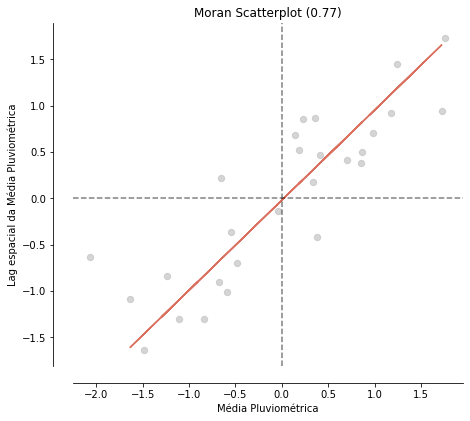

In [43]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
ax.set_xlabel('Média Pluviométrica')
ax.set_ylabel('Lag espacial da Média Pluviométrica')
plt.show()

O valor do Moran's I é o coeficiente da reta de regressão entre a `Média pluviométrica` e `lag(Média pluviométrica)`.

* #### Autocorrelação espacial local

Aqui, é feita a decomposição do Moran’s I de forma a construir uma medida localizada de autocorrelação. A ideia é encontrar _hot spots_ e _cold spots_, que são regiões em que se encontram respectivamente pontos com maior e menor correlação espacial.

In [44]:
moran_loc = Moran_Local(y, weights)

Fazemos um _scatterplot_ que divide as áreas em 4 grupos:

- _High-high_: 1º quadrante (em vermelho no gráfico)
- _Low-high_: 2º quadrante
- _Low-low_: 3º quadrante (em amarelo no gráfico)
- _High-low_: 4º quadrante

O parâmetro `p` é o p-valor que caracteriza o limite de significância no Moran's Local:

- Os pontos são coloridos de **vermelho** se forem considerados _hot spots_
- Os pontos são coloridos de **azul escuro** se forem considerados _cold spots_

Os pontos ainda podem ser coloridos de **amarelo** ou de **azul claro**, se forem respectivamente _High-Low_ ou _Low-High_. Os pontos em cinza não se caracterizam nem como _hot spots_ nem como _cold spots_.

Manteremos nosso `p` igual a 5%.

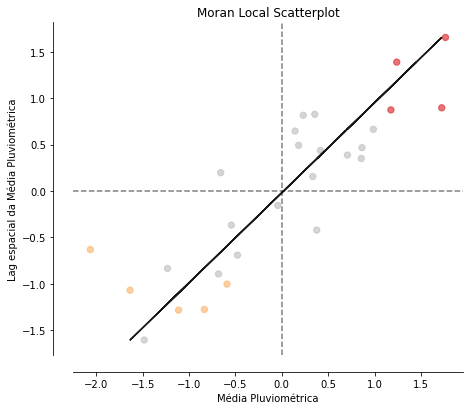

In [45]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Média Pluviométrica')
ax.set_ylabel('Lag espacial da Média Pluviométrica')
plt.show()

* Visualizamos os clusters em um mapa

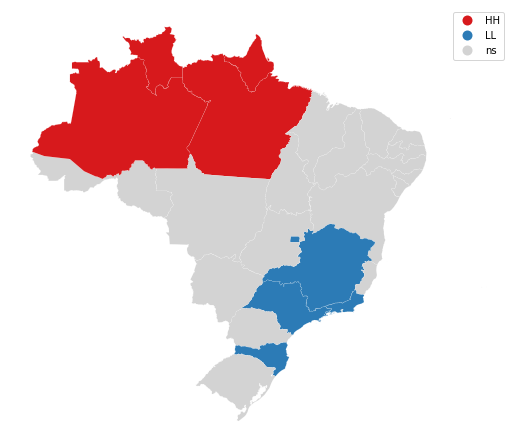

In [46]:
lisa_cluster(moran_loc, df_final, p=0.05, figsize=(9,9))
plt.show()

* Visão combinada

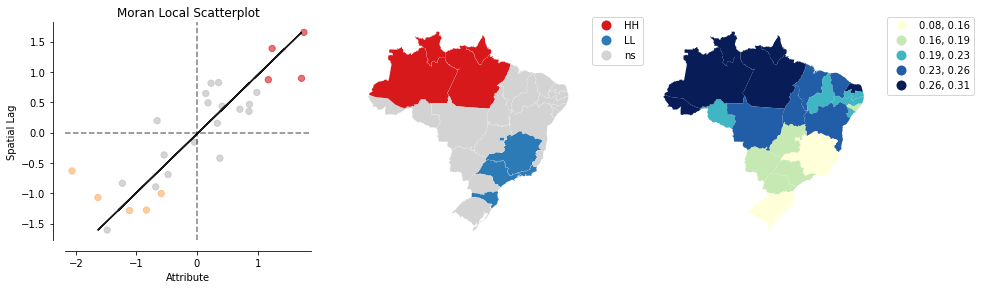

In [47]:
plot_local_autocorrelation(moran_loc, df_final, 'MÉDIA PLUVIOMÉTRICA EM ABR/2021')
plt.show()

Observamos que os estados do AM, RR, PA, AP ao norte do país têm uma tendência a ter regiões de alta pluviometria vizinhas de regiões de alta pluviometria, ao passo que bnoa parte dos estados no sul e sudeste do país têm uma tendência a terem regiões de baixa pluviometria vizinhas de regiões de baixa pluviometria.

Percebemos que existe uma forte tendência Sul-Sudeste (LL = menor pluviometria) em direção ao Norte (HH = Alta pluviometria).

## Bivariate Moran's I

* Preparação dos dados

Aqui, vamos avaliar o grau de correlação espacial de **duas variáveis.**

Assim como no [artigo 1](https://marcospaulomoretti.medium.com/autocorrela%C3%A7%C3%A3o-espacial-382c5af6d2ed), vamos tomar a variável temperatura e calcular o grau de correlação espacial dessas duas variáveis.

Para isso, vamos pegar os campos `TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)` e `TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)`, tirar a média, e em seguida tirar a média por estado, como fizemos com a pluviometria.

O significado dos campos foi obtido do Glossário de Dados do INMET [[7]](#refs).

In [48]:
df_temperatura = df_meteorologicos[["Data", "Hora UTC", "Região", "UF", "Cidade", "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"]]

In [49]:
df_temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696320 entries, 0 to 1696319
Data columns (total 7 columns):
 #   Column                                      Dtype 
---  ------                                      ----- 
 0   Data                                        object
 1   Hora UTC                                    object
 2   Região                                      object
 3   UF                                          object
 4   Cidade                                      object
 5   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  object
 6   TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  object
dtypes: object(7)
memory usage: 90.6+ MB


Transformamos os campos de data e de temperatura

In [50]:
df_temperatura["Data"].value_counts(dropna=False).sort_index()

2021/01/01    14136
2021/01/02    14136
2021/01/03    14136
2021/01/04    14136
2021/01/05    14136
2021/01/06    14136
2021/01/07    14136
2021/01/08    14136
2021/01/09    14136
2021/01/10    14136
2021/01/11    14136
2021/01/12    14136
2021/01/13    14136
2021/01/14    14136
2021/01/15    14136
2021/01/16    14136
2021/01/17    14136
2021/01/18    14136
2021/01/19    14136
2021/01/20    14136
2021/01/21    14136
2021/01/22    14136
2021/01/23    14136
2021/01/24    14136
2021/01/25    14136
2021/01/26    14136
2021/01/27    14136
2021/01/28    14136
2021/01/29    14136
2021/01/30    14136
2021/01/31    14136
2021/02/01    14136
2021/02/02    14136
2021/02/03    14136
2021/02/04    14136
2021/02/05    14136
2021/02/06    14136
2021/02/07    14136
2021/02/08    14136
2021/02/09    14136
2021/02/10    14136
2021/02/11    14136
2021/02/12    14136
2021/02/13    14136
2021/02/14    14136
2021/02/15    14136
2021/02/16    14136
2021/02/17    14136
2021/02/18    14136
2021/02/19    14136


In [51]:
df_temperatura["Data"] = pd.to_datetime(df_temperatura["Data"], format="%Y/%m/%d")

C:\Users\marco\anaconda3\envs\spatial\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [52]:
df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].value_counts(dropna=False)

NaN      669517
23,3       9750
23,5       9717
23,6       9659
23,7       9642
23,8       9631
23,1       9578
23,2       9565
23,4       9503
24         9469
23,9       9388
23         9285
24,1       9263
24,2       9258
24,3       9226
24,4       9210
22,9       9200
22,8       9161
22,7       9004
24,5       8874
22,5       8839
24,6       8682
22,6       8658
24,7       8604
22,4       8590
22,3       8562
24,8       8435
24,9       8311
22,2       8306
25         8214
22,1       8186
25,1       8133
21,9       8105
22         8015
25,2       8012
25,3       7945
25,4       7899
21,8       7857
25,5       7798
25,6       7626
21,7       7502
25,7       7359
21,6       7338
25,8       7333
26,1       7298
25,9       7279
21,5       7179
21,4       7134
26,3       7057
26,2       7008
26         7002
21,3       6933
21,2       6875
21,1       6830
26,4       6806
21         6735
26,7       6729
26,5       6679
26,6       6669
20,9       6491
26,8       6439
20,8       6420
27      

In [53]:
df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].value_counts(dropna=False)

NaN      667049
23,1      10794
23        10738
23,2      10634
23,4      10568
22,8      10561
23,5      10551
23,3      10501
22,7      10497
22,9      10465
23,6      10445
22,6      10404
23,7      10380
23,8      10325
22,5      10238
22,4      10224
22,3      10060
23,9       9970
24         9865
22,2       9802
24,1       9712
22,1       9628
22         9604
21,9       9549
24,2       9465
24,3       9395
21,8       9341
21,7       9341
24,4       9234
24,5       9131
21,6       8976
24,6       8925
24,7       8918
21,5       8851
21,4       8802
24,8       8545
21,2       8536
24,9       8498
21,3       8411
21         8208
25         8189
25,1       8138
21,1       8125
20,9       8039
25,3       7986
25,2       7966
20,8       7782
20,7       7729
25,4       7701
25,5       7615
20,6       7571
20,5       7562
25,6       7395
20,4       7343
20,2       7294
20,3       7231
25,7       7190
25,9       7069
25,8       7064
20         6953
20,1       6931
26,1       6846
26      

In [54]:
df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"] = df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(np.float64)
df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"] = df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(np.float64)

Vamos utilizar somente os dados de abril de 2021

In [55]:
df_temperatura = df_temperatura[(df_temperatura["Data"] >= "2021-04-01") & (df_temperatura["Data"] <= "2021-04-30")]

In [56]:
print(f"Temos dados de {len(df_temperatura['UF'].unique())} UFs em 2021-04.")

Temos dados de 27 UFs em 2021-04.


In [57]:
df_temperatura

,Data,Hora UTC,Região,UF,Cidade,TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)
2160,2021-04-01,0000 UTC,CO,DF,BRASILIA,22.7,19.8
2161,2021-04-01,0100 UTC,CO,DF,BRASILIA,21.0,19.7
2162,2021-04-01,0200 UTC,CO,DF,BRASILIA,21.2,20.8
2163,2021-04-01,0300 UTC,CO,DF,BRASILIA,21.5,18.9
2164,2021-04-01,0400 UTC,CO,DF,BRASILIA,19.8,18.9
...,...,...,...,...,...,...,...
1696315,2021-04-30,1900 UTC,S,SC,CAMPOS NOVOS,21.1,20.2
1696316,2021-04-30,2000 UTC,S,SC,CAMPOS NOVOS,20.7,19.5
1696317,2021-04-30,2100 UTC,S,SC,CAMPOS NOVOS,19.6,17.1
1696318,2021-04-30,2200 UTC,S,SC,CAMPOS NOVOS,17.1,15.0


Vamos ver os nulos

In [58]:
df_temperatura.isnull().sum()

Data                                               0
Hora UTC                                           0
Região                                             0
UF                                                 0
Cidade                                             0
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)    183163
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)    182448
dtype: int64

Vamos substituir os nulos nas temperaturas pela média da região em que o estado se encontra

In [59]:
medias_max_por_regiao = df_temperatura.groupby("Região")["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].mean()
medias_max_por_regiao

Região
CO    24.486163
N     26.598875
NE    26.570214
S     19.634575
SE    21.985178
Name: TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C), dtype: float64

In [60]:
medias_min_por_regiao = df_temperatura.groupby("Região")["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].mean()
medias_min_por_regiao

Região
CO    23.026874
N     25.518037
NE    25.379140
S     18.364195
SE    20.576687
Name: TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C), dtype: float64

In [61]:
for regiao in ["CO", "N", "NE", "S", "SE"]:
    idx_max = df_temperatura[(df_temperatura["Região"] == regiao) & (df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].isna())].index
    df_temperatura.loc[idx_max, "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"] = medias_max_por_regiao[regiao]
    idx_min = df_temperatura[(df_temperatura["Região"] == regiao) & (df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].isna())].index
    df_temperatura.loc[idx_min, "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"] = medias_min_por_regiao[regiao]

In [62]:
df_temperatura.isnull().sum()

Data                                          0
Hora UTC                                      0
Região                                        0
UF                                            0
Cidade                                        0
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)    0
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)    0
dtype: int64

Vamos tirar a média da temperatura máxima e da mínima em cada cidade.

In [63]:
df_temperatura["Temperatura média (°C)"] = (df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"] + df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"]) / 2

Em seguida, vamos tirar a média por estado.

In [64]:
medias_por_uf = df_temperatura.groupby("UF")["Temperatura média (°C)"].mean()
medias_por_uf

UF
AC    25.919141
AL    26.362708
AM    26.239004
AP    25.982004
BA    25.641489
CE    26.065221
DF    21.094835
ES    22.763599
GO    23.427315
MA    26.343923
MG    21.584905
MS    23.901011
MT    24.171803
PA    26.068170
PB    25.499259
PE    26.002614
PI    26.230398
PR    19.069152
RJ    21.565253
RN    26.471521
RO    25.574107
RR    26.058456
RS    19.411082
SC    18.169029
SE    25.873476
SP    20.187138
TO    26.032314
Name: Temperatura média (°C), dtype: float64

In [65]:
df_medias_temperatura = pd.DataFrame(medias_por_uf).reset_index()
df_medias_temperatura.rename(columns={"Temperatura média (°C)" : "Média da temperatura média (°C) em ABR/2021"}, inplace=True)
df_medias_temperatura

,UF,Média da temperatura média (°C) em ABR/2021
0,AC,25.919141
1,AL,26.362708
2,AM,26.239004
3,AP,25.982004
4,BA,25.641489
5,CE,26.065221
6,DF,21.094835
7,ES,22.763599
8,GO,23.427315
9,MA,26.343923


In [66]:
df_medias_temperatura.sort_values(by="Média da temperatura média (°C) em ABR/2021", ascending=False)

,UF,Média da temperatura média (°C) em ABR/2021
19,RN,26.471521
1,AL,26.362708
9,MA,26.343923
2,AM,26.239004
16,PI,26.230398
13,PA,26.068170
5,CE,26.065221
21,RR,26.058456
26,TO,26.032314
15,PE,26.002614


Como esperado, as temperaturas médias nas regiões Nordeste e Norte são em geral mais elevadas.

Criamos um dataframe com o Geometry (em `gdf`), o dado de temperatura e o dado pluviométrico. Assim, acabamos por ordenar a variável de Média Pluviométrica de acordo com a ordenação dos estados em `gdf`.

In [67]:
# Merge dos dados pluviométricos
df_final = pd.merge(
    gdf,
    df_medias_pluviometricas,
    left_on="SIGLA_UF",
    right_on="UF",
    how="left"
)

# Merge dos dados de temperatura
df_final = pd.merge(
    df_final,
    df_medias_temperatura,
    left_on="SIGLA_UF",
    right_on="UF",
    how="left"
)

In [68]:
df_final.drop(columns=["UF_x", "UF_y"], inplace=True)

In [69]:
df_final

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,MÉDIA PLUVIOMÉTRICA EM ABR/2021,Média da temperatura média (°C) em ABR/2021
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",0.219522,25.574107
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828...",0.265189,25.919141
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620...",0.276650,26.239004
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416...",0.280433,26.058456
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...",0.309737,26.068170
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",0.312160,25.982004
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23291 -5.94757, -48.23163 -5.946...",0.248314,26.032314
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.96620 -1.27114, -44.96081 ...",0.227068,26.343923
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91509 -6.64795, -42.91636 -6.644...",0.216508,26.230398
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017...",0.257359,26.065221


* ### Moran's I Bivariado Global

In [70]:
help(Moran_BV)

Help on class Moran_BV in module esda.moran:

class Moran_BV(builtins.object)
 |  Moran_BV(x, y, w, transformation='r', permutations=999)
 |  
 |  Bivariate Moran's I
 |  
 |  Parameters
 |  ----------
 |  x : array
 |      x-axis variable
 |  y : array
 |      wy will be on y axis
 |  w : W
 |      weight instance assumed to be aligned with y
 |  transformation  : {'R', 'B', 'D', 'U', 'V'}
 |                    weights transformation, default is row-standardized "r".
 |                    Other options include
 |                    "B": binary,
 |                    "D": doubly-standardized,
 |                    "U": untransformed (general weights),
 |                    "V": variance-stabilizing.
 |  permutations    : int
 |                    number of random permutations for calculation of pseudo
 |                    p_values
 |  
 |  Attributes
 |  ----------
 |  zx            : array
 |                  original x variable standardized by mean and std
 |  zy            : array


Como temos duas variáveis, precisamos saber se vamos calcular o _lag_ da `Média da temperatura` ou da `Média da pluviometria`.

Vamos supor que queremos entender se a temperatura está influenciando na pluviometria da vizinhança de uma dada região. Neste caso, nossa variável referência `x` é a `Média da temperatura`, ao passo que `y` é a `Média da pluviometria`, da qual calcularemos o _lag_.

In [71]:
x = df_final['Média da temperatura média (°C) em ABR/2021'].values
y = df_final['MÉDIA PLUVIOMÉTRICA EM ABR/2021'].values # variável que utilizaremos como lag

In [72]:
moran_bv = Moran_BV(x, y, weights)

É importante notar que `Moran_BV(x, y, weights) != Moran_BV(y, x, weights)`, pois estamos calculando o _lag_ com variáveis diferentes.

In [73]:
moran_bv.I

0.7430276815572839

O valor de autocorrelação é **positivo.**

- Cálculo da significância

Faremos da mesma forma que o cálculo do Moran's I univariado. Vamos utilizar permutações para rejeitar a hipótese nula (H0) de aleatoriadade espacial dos `y` com significância (p-valor) de 5%.

In [74]:
print("Significância em relação à distribuição dos índices I, após permutações aleatórias de y no espaço:")
print(f"Qtde. de permutações = 999")
print(f"Esperança de I       = {moran_bv.EI_sim}")
print(f"P-valor de I         = {moran_bv.p_sim}")

Significância em relação à distribuição dos índices I, após permutações aleatórias de y no espaço:
Qtde. de permutações = 999
Esperança de I       = 0.00385668186092076
P-valor de I         = 0.001


Percebemos que o índice obtido é bem maior que a média esperada, e **é significativo** em relação a um grau de significância de 5% (p-valor = 0.001 < 5%). 

Ou seja, existe uma correlação espacial positiva entre pluviometria e temperatura.

- Visualização do Moran's I

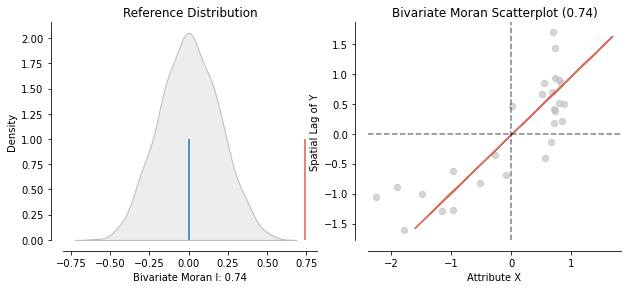

In [75]:
plot_moran_bv(moran_bv)
plt.show()

Aqui podemos observar a distribuição normal de referência para o Moran's index, e a linha vermelha à direita mostra o valor de `moran_bv.I` obtido. O valor da área sob a curva, para `bv_index > 0.74` é menor que o p-valor, de modo que rejeitamos a hipótese nula (H0) de distribuição aleatória de `y`.

* ### Moran's I Bivariado Local

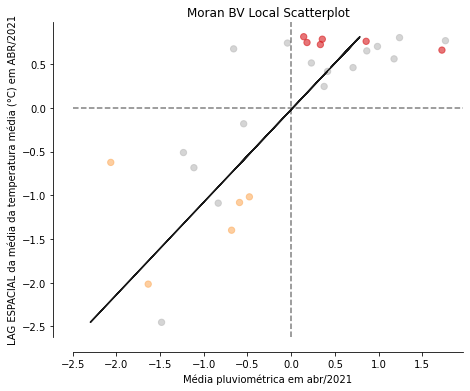

In [76]:
moran_loc_bv = Moran_Local_BV(y, x, weights)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Média pluviométrica em abr/2021')
ax.set_ylabel('LAG ESPACIAL da média da temperatura média (°C) em ABR/2021')
plt.show()

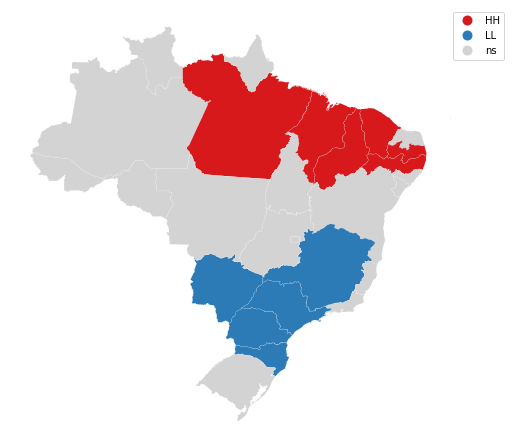

In [77]:
lisa_cluster(moran_loc_bv, df_final, p=0.05, figsize=(9,9))
plt.show()

Observamos que os estados do AM, RR, PA, AP ao norte do país têm uma tendência a ter regiões de alta pluviometria vizinhas de regiões de alta temperatura, ao passo que os estados no sul e sudeste do país têm uma tendência a terem regiões de baixa pluviometria vizinhas de regiões de baixa temperatura.

Isso configura uma tendência parecida com a que foi vista para pluviometria, de modo que temperatura parece seguir a mesma tendência espacial.

## Conclusão

Podemos constatar que no mês de abril de 2021, de fato, existe uma tendência espacial na Média pluviométrica, e que a distribuição das Médias das temperaturas no espaço sugere uma influência espacial da temperatura na pluviometria das regiões.

De fato, podemos observar que principalmente no Sul e no Sudeste do Brasil temos _cold spots_, ao passo que no Norte temos _hot spots_ de pluviometria, o que parece fazer sentido se considerarmos o perfil climatológico brasileiro.

Em todo caso, por mais que os p-valores informem que existe significância no valores de Moran's index obtidos, é importante ressaltar a máxima que **correlação não implica causalidade**. Então, no caso bivariado, por exemplo, não podemos afirmar que a pluviometria alta nos _hot spots_ seja a causa de um aumento de temperatura na vizinhança devido à alta correlação obtida, mas sim que os valores seguem uma tendência espacial semelhante.

<a id="refs"></a>
## Referências

[1] https://www.biomedware.com/files/documentation/clusterseer/Concepts/Polygon_contiguity.htm

[2] http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html

[3] Histórico de Dados Meteorológicos (2021) - Instituto Nacional de Meteorologia:
https://portal.inmet.gov.br/dadoshistoricos

[4] https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm

[5] https://aurin.org.au/resources/workbench-user-guides/portal-user-guides/analysing-your-data/spatial-autocorrelation-tools/bivariate-morans-i/

[6] https://splot.readthedocs.io/en/stable/users/tutorials/autocorrelation.html#moran-s-i

[7] Glossário de dados:
https://portal.inmet.gov.br/glossario/glossario
(Procurar TEMPERATURA MÉDIA)

- Outras referências:

[.] https://nbviewer.jupyter.org/github/pysal/libpysal/blob/master/notebooks/weights.ipynb

[.] Malha municipal - IBGE:
https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html?=&t=downloads